# Bagging

## 1. Introduction to Ensemble methods and Bagging 

<b>Bagging</b> is an <b>ensemble method</b> used in machine learning that can be applied to almost any <b>base learner</b> model. Generally speaking, it reduces the <b>variance</b> of the model while maintains the low <b>bias</b> of the model. You may see a lot of new terminologies here that seems overwhelming. No worries, we will go over these concepts one by one. So far all you need to know it that bagging helps us develop a more reliable model. In this code assignment we will be starting from scratch and build up these concepts with yout knowledge in EE16A EE16B and CS61B. 

Here is the outline of the assignment. If you are already familiar with some concept, you can feel free to skim through the part.  
1. Machine learning Basics recap <br>
    1.1 Linear regression <br>
    1.2 Polynomial regression <br>
    1.3 Overfitting<br>
2. Bias and Variance <br>
    2.1 Bagging: an experiment <br>
    2.2 Bagging theory <br>
3. Bootstrap <br>
4. K-fold cross-validation <br>
5. Decision Tree <br>
    5.1 Overfitting <br>
    5.2 Bagged trees <br>
    5.3 Random forest <br>


### 1.1 EE16A ML Recap

In [120]:
import sklearn.svm as svm
import sklearn.datasets as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D
import sys
!{sys.executable} -m pip install mlxtend

In EE16A, we have learned about the basics of machine learning: identifying the problem of classification, estimation, prediction and clustering, mastering some linear algebra techniques to solve machine learning problem, eg. least square, optimizing a loss function. (vFor a quick 16A ML recap please go to https://inst.eecs.berkeley.edu/~ee16a/fa19/lecture/2019-11-12_11A.pdf ) Let's start with a set of problem that we are all familiar with in EE16A, "the line of best fit" problems. 

### ex.1 Linear regression 

In this simple exercise, we will be dealing with a toy example that helps you recap the setting of linear regression. You will also be able to bridge the gap between linear algebra and the larger setting of machine learning problem. Let's say that we are given a set of peerfectly linearly correlated data and we would like to figure out the exact formulation of their relations. We learned in the EE16A that we could formulate the problem as a least square problem and find its solution.

In [121]:
""" Here we create a set of linearly correlated points: wx + b = y. Here w and b are unknown.
"""
w = 1.5
b = 30
xs, ys = [], []
for i in range(100):
    x = 100 * random.random() - 50
    xs.append(x)
    ys.append(w * x + b)

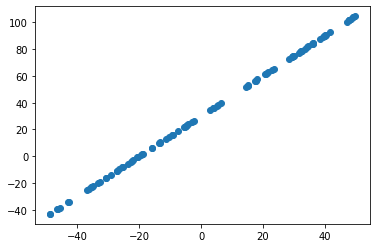

In [122]:
plt.scatter(xs,ys)

Here we know $X$ and $y$ . We can then formulate the problem as $$Ax = b$$  
$$A = \begin{bmatrix}
x_1 & 1 \\
x_2 & 1 \\
x_3 & 1 \\
\vdots  & \vdots \\
x_m & 1
\end{bmatrix}$$


$$b = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots\\
y_m
\end{bmatrix}$$ 



<b>Q1:</b> Derive the algebric solution to the Least square problem.

In [123]:
""" Linear Algebra way of solving it comes by matrix calculation
"""
X_s = np.vstack([xs, np.ones(len(xs))]).T
w, b = np.linalg.inv(X_s.T @ X_s)@ X_s.T @ ys
w, b

(1.5, 30.0)

<b>Q2:</b> Use Numpy's Least square method to code up the solution

In [124]:
""" Using Numpy's Least square solution
"""
X_s = np.vstack([xs, np.ones(len(xs))]).T
np.linalg.lstsq(X_s,ys, rcond = None) [0]

array([ 1.5, 30. ])

After these calculation we are able to obtain the predicted $Y$<sub>pred</sub> for any given $x$. By far you should be familiar with the pipeline of a basic machine learning problem.

### ex.2. Polynomial Regression

The previous example is set the stage for a larger set of regression problem called polynomial regression. Here we will give you some example to understand the set of regression problem better. Say our ground truth model is a second degree polynomial. If we used linear regression to model the problem, what problem will we have?

Write your observation here:

[]

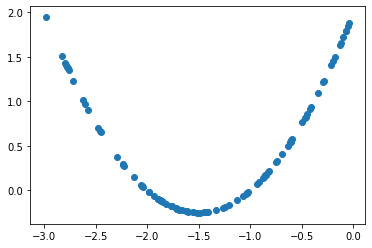

In [125]:
""" The ground truth data is modeled by a second degree polynomial. y = x**2 + 3x +2
"""
x_s, y_s = [], []
for i in range(100):
    x = 3 * random.random() - 3
    x_s.append(x)
    y_s.append(x**2 + 3*x +2)
x_s = np.array(x_s)
plt.scatter(x_s,y_s)
plt.plot()

First let us use linear method to model this polynomial data. Plot the line you get on the graph.

In [126]:
def plot_best_fit_poly(x_s, y_s,deg):
    coefficients = np.polyfit(x_s, y_s, deg=deg)
    poly = np.poly1d(coefficients)
    new_x = np.linspace(min(x_s), max(x_s))
    new_y = poly(new_x)
    plt.figure()
    plt.plot(x_s, y_s,"o", new_x, new_y, linewidth = 3)
    plt.legend(('polynomial data', str(deg)+'th degree approximation'),
           loc='upper right')
    plt.show()
    print('this is best fitted polynomial for degree' + str(deg))
    

In [127]:
X_s = np.vstack([x_s, np.ones(len(x_s))]).T
w, b =np.linalg.lstsq(X_s,y_s, rcond = None) [0]

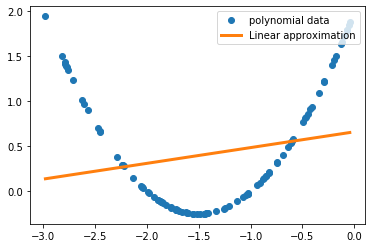

In [128]:
new_x = np.linspace(min(x_s), max(x_s))
new_y = w * new_x + b
plt.plot( x_s,y_s, 'o', new_x, new_y, linewidth = 3)
plt.legend(('polynomial data', 'Linear approximation'),
           loc='upper right')

Numpy method polyfit will help you find the coefficient of polynomial given all the points on the curve. Please derive the most fitted the polynomial and plot it on top of the points.

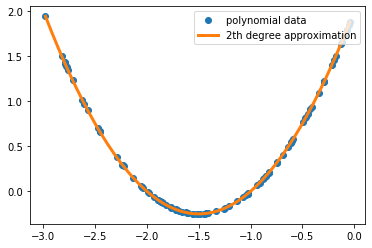

this is best fitted polynomial for degree2


In [129]:
plot_best_fit_poly(x_s, y_s,2)

Now, try using polynial of degree 3,5,10 to model the second degree polynomial example. What do you find?

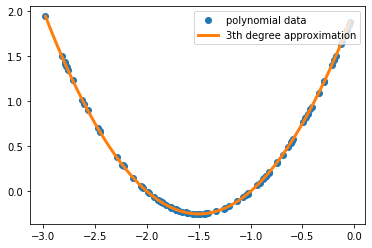

this is best fitted polynomial for degree3


In [130]:
plot_best_fit_poly(x_s, y_s,3)

If we use degree 3,5,100, we will get the same result! Since we are ust putting all the terms over 2 degree to zero. Now it seems that there is an advantage to use higher degree polynomials, since it is more expressive and coudl model all sorts of functions. Is this the real case? Let's go into the next section and examine the case when we have imperfect data from real life.

### ex.3. Error term

In real life, it is almost impossible to get a set of perfect gauched data. There is a thousand ways to get things wrong. In this part, let jump out of the perfect examples and step our foot in the real life scenarios with error.

In [131]:
""" We manually plant some noises in the data, an error term that N: (0,0.5)
"""
errors = []
for i in range(100):
    errors.append(random.gauss(0,0.5))
y_with_error = np.add(y_s,errors)

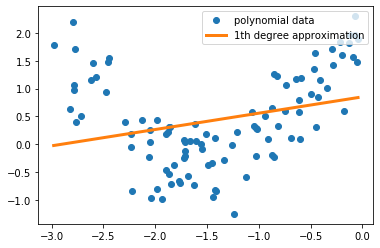

this is best fitted polynomial for degree1


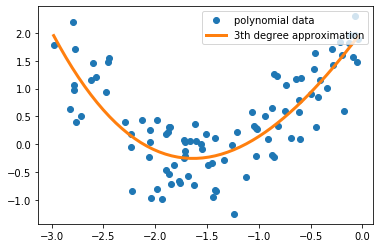

this is best fitted polynomial for degree3


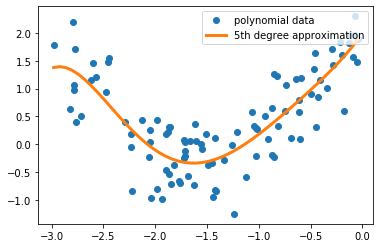

this is best fitted polynomial for degree5


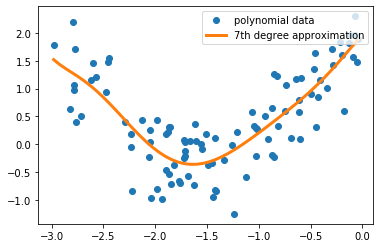

this is best fitted polynomial for degree7


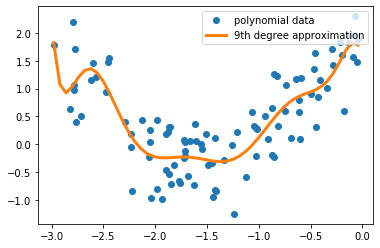

this is best fitted polynomial for degree9


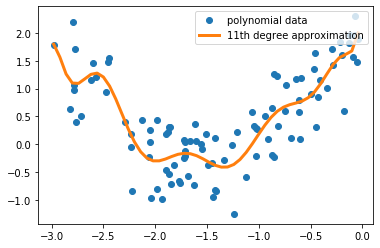

this is best fitted polynomial for degree11


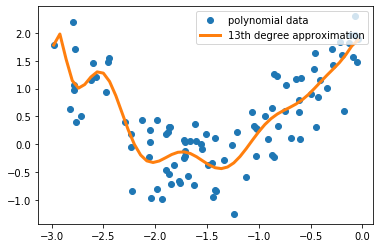

this is best fitted polynomial for degree13


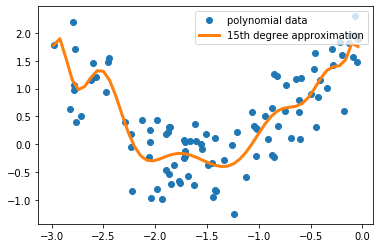

this is best fitted polynomial for degree15


In [132]:
"""Compare the ground truth and the classifier we get with the noisy data"""
for i in range(1,17,2):
    plot_best_fit_poly(x_s, y_with_error,i)

As you can see, as we increase the polynomial term, the decision boundry becomes spiky. We relate this observation to the idea of overfitting: using a too complicated model to capture the nitty gritty of the data while not being able to generalize to other data. We often tie the idea of overfitting to high variance. If you select a bunch of samples from a population repeatedly whiling use an overfitting model, chances are that all the models you get each time will cater to the selected population and will vary to each other a lot. This is what we mean by high variance. In the next section, we will be exploring the bias variance trade off empirically.

## Variance and Bias: a brief recap

In Week 2, we have learned about bias-variance decomposition. We learned about varince bias decomposition which consists of three terms: bias of the method, variance of the method and irreducible error. Let's first do a basic exericse to recap the concept.

In [133]:
"""Ground Truth Function y = x + sin(1.5x) + """

'Ground Truth Function y = x + sin(1.5x) + '

In [134]:
"""Ground Truth Function y = x + sin(1.5x), observed data y_obs = x + sin(1.5) + N(0,1)"""
x_obs, y_obs = [],[]
for i in range(100):
    x = random.random() * 4 - 2
    x_obs.append(x)
    y_obs.append(x+ np.sin(1.5*x)+random.gauss(0,0.5))

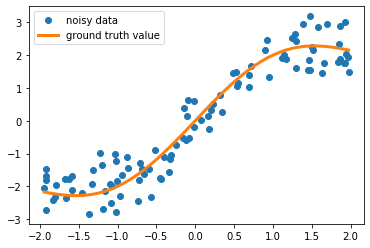

In [135]:
new_x = np.linspace(min(x_obs), max(x_obs))
new_y = new_x + np.sin(1.5 * new_x)
plt.plot(x_obs, y_obs,'o',new_x, new_y, linewidth = 3)
plt.legend(("noisy data","ground truth value"), loc = "upper left")

Let's get 20 separate observation dataset from the underlying function. Notice that we have a gaussian error term $N~(0,0.5)$ that will make each dataset different.

In [136]:
def gen_data(num):
    x_data,y_data = [],[]
    for i in range(num):
        x_obs, y_obs = [],[]
        for i in range(100):
            x = random.random() * 4 - 2
            x_obs.append(x)
            y_obs.append(x+ np.sin(1.5*x)+random.gauss(0,0.5))
        x_data.append(x_obs)
        y_data.append(y_obs)
    return x_data, y_data

In [137]:
x_bundle, y_bundle = gen_data(20)

In [138]:
""" Simulate the data with degree 1-4 polynomial and report the variance and bias of the result
"""
def bias_variance_demo(degree):
    coeffs = []
    for i in range(20):
        x_s = x_bundle[i]
        y_s = y_bundle[i]
        coefficients = np.polyfit(x_s, y_s, deg=degree)
        coeffs.append(coefficients)
        poly = np.poly1d(coefficients)
        new_x1 = np.linspace(min(x_s), max(x_s))
        new_y1 = poly(new_x1)
        #plt.figure()
        plt.plot(new_x1, new_y1, linewidth = 0.5)
    mean_coeff = np.mean((coeffs),axis = 0)
    mean_y = np.poly1d(mean_coeff)(new_x)
    plt.plot(new_x, mean_y, linewidth = 2, label = 'approximation')
    plt.plot(new_x, new_y, linewidth = 2, label = 'ground truth')
    plt.legend(loc = 'upper left')
    plt.title(str(degree) + "th degree polynomial simulation of the function x+ sin(1.5*x)")
    plt.show()
    
        
    bias = abs(sum(mean_y - new_y))
    y_s = []
    for i in range(20):
        coeff = coeffs[i]
        poly = np.poly1d(coeff)
        y_s.append(poly(new_x))    
    variance = np.var(y_s)
    print("bias is " + str(bias))
    print("variance is " + str(variance))
    print("bias**2 + variance = " + str(bias**2+variance))

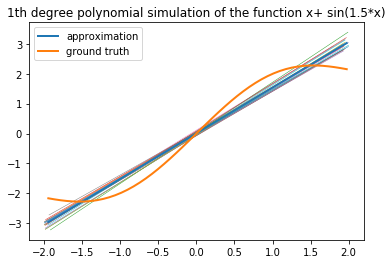

bias is 0.796076768210197
variance is 3.1239005331372884
bias**2 + variance = 3.75763875402128


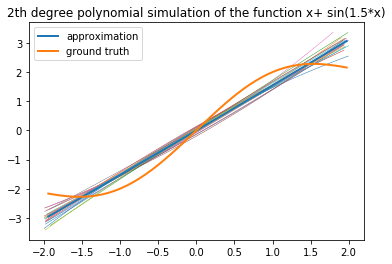

bias is 0.7369603313286657
variance is 3.156641616357383
bias**2 + variance = 3.6997521463094394


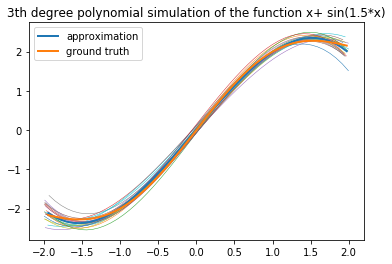

bias is 0.009364763859426417
variance is 3.264904371091496
bias**2 + variance = 3.2649920698936388


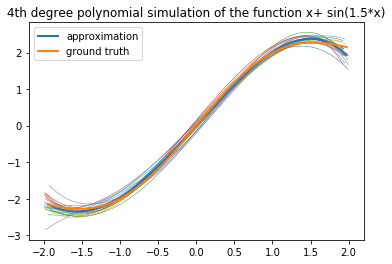

bias is 0.0473813476622153
variance is 3.2710980612295235
bias**2 + variance = 3.2733430533358114


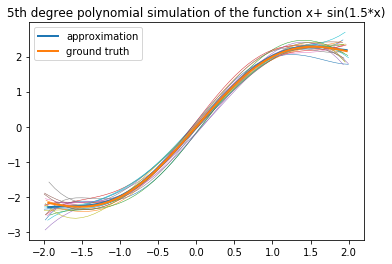

bias is 0.17888292419855195
variance is 3.2782190081595193
bias**2 + variance = 3.310218108729344


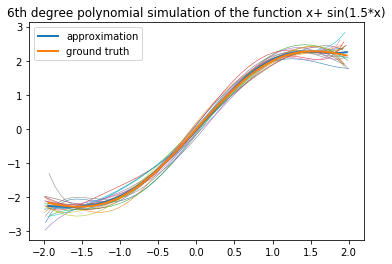

bias is 0.2653985453907412
variance is 3.2899041655532555
bias**2 + variance = 3.360340553448777


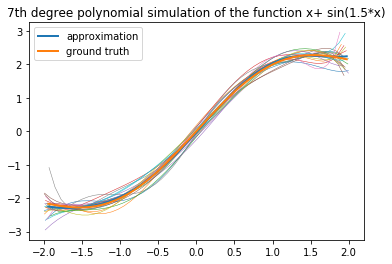

bias is 0.19613502592829202
variance is 3.293640487771555
bias**2 + variance = 3.332109436167447


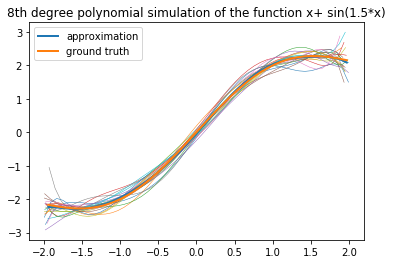

bias is 0.04932583801747534
variance is 3.2728964473650977
bias**2 + variance = 3.275329485661224


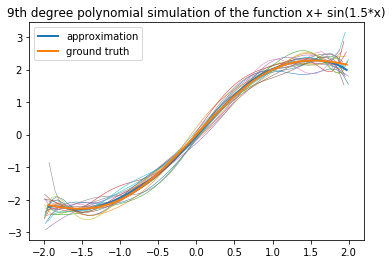

bias is 0.02599235623447227
variance is 3.2593461389478744
bias**2 + variance = 3.260021741530494


In [139]:
for deg in range(1,10):
    bias_variance_demo(deg)

One would observe that as the degree of polynomial increases the bias is steadily decreasing yet the variance is increasing. Why is that? You should already encounter the concept of bias variance decomposition in previous weeks and in notes.

### Bagging: An experiment

Indeed, different learners and model classes have different tradeoffs.  

– large bias/small variance: few features, highly regularized, highly pruned decision trees, large-k kNN etc  
– small bias/high variance: many features, less regularization, small-k k-NN etc

A natural questions arises as well deal with models with low bias and high variance. How can we prevent them from overfitting? From the previous part, we find that the mean model is much mroe smoothened out. From there, one natural intuition arises: averaging out the result of the model. In the previous example, we had 20 datasets generated from the underlying ground truth function. In real life, we only have one set of dataset and we do not have the gournd truth function. How could we generate all the datasets? We used the idea of bootstrap.

#### Polynomial example

### Bagging Theory

<img src="https://miro.medium.com/max/700/1*_pfQ7Xf-BAwfQXtaBbNTEg.png">
From the previous example, we can see that bagging can somehow avoid overfitting and get some pretty good result. From a theoretic pespective how does it really work?

When we do bagging, we first bootstrap M different samples without replacement from the population. Since we are sampling without replacement, then these samples are independent of each other. Thus we name them as $Y_1, Y_2, ..., Y_m$ independent random variables each with mean $\mu$ and variance $\sigma ^2$. As we average them, we are basically taking the expectation of the following terms which you will see is still $\mu$ $$ \frac{1}{M}  \sum_{i=1}^{M} Y_i = \frac{1}{M} \times {M \mu} = \mu $$ Therefore after all these mumble jumbles we still get that good low bias. As for variance, let's do our calculation: $$ var(\frac{1}{M}\sum_{i=1}^{M} Y_i) = \frac{1}{M^2} \times var(\sum_{i=1}^{M} Y_i) = \frac{1}{M^2} \times \sigma^2 \times M  = \frac{\sigma^2} {M} $$ As we can see the variance goes down linearly as M increases. This is the exact reason why we are able to get a better result in the end.

Now, observe the following results of applying bagging to two exising dataset:

In [140]:
from mlxtend.evaluate import bias_variance_decomp
from sklearn.tree import DecisionTreeClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split


X, y = iris_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True,
                                                    stratify=y)



tree = DecisionTreeClassifier(random_state=123)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        tree, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.062
Average bias: 0.022
Average variance: 0.040


In [141]:
from mlxtend.evaluate import bias_variance_decomp

In [142]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(random_state=123)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=100,
                        random_state=123)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        bag, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.048
Average bias: 0.022
Average variance: 0.026


In [143]:
from mlxtend.evaluate import bias_variance_decomp
from sklearn.tree import DecisionTreeRegressor
from mlxtend.data import boston_housing_data
from sklearn.model_selection import train_test_split

X, y = boston_housing_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True)



tree = DecisionTreeRegressor(random_state=123)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        tree, X_train, y_train, X_test, y_test, 
        loss='mse',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 31.727
Average bias: 14.085
Average variance: 17.642


In [144]:
from sklearn.ensemble import BaggingRegressor

tree = DecisionTreeRegressor(random_state=123)
bag = BaggingRegressor(base_estimator=tree,
                       n_estimators=100,
                       random_state=123)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        bag, X_train, y_train, X_test, y_test, 
        loss='mse',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 18.600
Average bias: 15.445
Average variance: 3.155


In [145]:
import sklearn.svm as svm
import sklearn.datasets as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [146]:
import random

In [147]:
import pandas as pd

### Extracting Feature from the original csv File

In [148]:
df = pd.read_csv('Admission_Predict.csv', index_col='Serial No.')
df = df.dropna()
df

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
396,324,110,3,3.5,3.5,9.04,1,0.82
397,325,107,3,3.0,3.5,9.11,1,0.84
398,330,116,4,5.0,4.5,9.45,1,0.91


In [149]:
X = df.drop('Chance of Admit ', axis=1)

In [198]:
y_val = df['Chance of Admit '].values
y_val[y_val>0.8] = 1
y_val[y_val != 1] = 0
df['Chance of Admit '] = y_val
y = df['Chance of Admit ']
df

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,Square_SOP,Sqrt_GRE,Sqrt_Toefl
Serial No.,,,,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,1.0,9.0,18.357560,10.862780
2,324,107,4,4.0,4.5,8.87,1,1.0,8.0,18.000000,10.344080
3,316,104,3,3.0,3.5,8.00,1,1.0,6.0,17.776389,10.198039
4,322,110,3,3.5,2.5,8.67,1,1.0,7.0,17.944358,10.488088
5,314,103,2,2.0,3.0,8.21,0,0.0,4.0,17.720045,10.148892
...,...,...,...,...,...,...,...,...,...,...,...
396,324,110,3,3.5,3.5,9.04,1,1.0,7.0,18.000000,10.488088
397,325,107,3,3.0,3.5,9.11,1,1.0,6.0,18.027756,10.344080
398,330,116,4,5.0,4.5,9.45,1,1.0,10.0,18.165902,10.770330


# Bootstrap
If we randomly select some observations from dataset and use the sample to estimate some unknown value we want only once, the value cannot represent the real one. Instead, we can select sample multiple time, and average the value we found each time.It will make our prediction closer to the real value. That is the idea of Bootstrap. It is robustness and high efficiency because we do not need to add additional data.
Bootstrap can also be used to create randomness in data.
<img src="https://habrastorage.org/webt/n0/dg/du/n0dgduav1ygc3iylumtwjcn15mu.png">

*Cite: Image from https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-1-bagging*
Your task for this part is to use Bootstraping to find the average GRE score for students with `Chance of Admit` > 0.8.

a) Before we actually start, let try to find the mean of `GRE Score` in this whole dataset.

In [199]:
real_mean = np.mean(df["GRE Score"])
print(real_mean)

316.8075


b) Select 320 students randomly without replacement, and store the content in the variable called `sample`.

In [200]:
sample = df.sample(320, replace=False)
sample.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,Square_SOP,Sqrt_GRE,Sqrt_Toefl
Serial No.,,,,,,,,,,,
26,340,120,5,4.5,4.5,9.60,1,1.0,9.0,18.439089,10.954451
154,324,105,3,3.0,4.0,8.75,0,1.0,6.0,18.000000,10.246951
172,334,117,5,4.0,4.5,9.07,1,1.0,8.0,18.275667,10.816654
149,339,116,4,4.0,3.5,9.80,1,1.0,8.0,18.411953,10.770330
8,308,101,2,3.0,4.0,7.90,0,0.0,6.0,17.549929,10.049876


c) In `sample` dataframe, find the average of GRE Score.

In [201]:
mean = np.mean(sample['GRE Score'])
mean

316.96875

d) Part (b) and (c) show the process of sampleing and finding the mean of sampled `GRE Score`. Now complete bootstrap function, so that we can run this processes multiple times. 

In [202]:
def bootstrap(dataframe, n):
    avg = []
    for i in np.arange(n):
        bootstrap_sample = dataframe.sample(320, replace=False)
        new_avg = np.mean(bootstrap_sample['GRE Score'])
        avg = np.append(avg, new_avg)
    
    mean = np.mean(avg)
    return mean

In [203]:
bootstrap(df, 300)

316.7944791666667

# K-Fold Cross-Validation
In the case of insufficient dataset, we can use K-Fold Cross-Validation to maximize the use of the dataset. 

As you can see in the following image, after separate the dataset into training set and test set, we initialize k, which is the number of folds that we want to separate in the training set. Then we separate the training set into k equally sized subset by using KFold() function. Then we can train our model on each split, and get the corresponding error rate each time. Finally, we average the error, and use it as an estimate of the accuracy of the model algorithm.

<img src="https://www.textbook.ds100.org/_images/bias_cv_5_fold_cv.jpg">

*Cite: Image from:https://www.textbook.ds100.org/ch/15/bias_cv.html?highlight=cross#k-fold-cross-validation*
In this part, we will use linear regression model to predicts TOEFL Score from GRE Score.

a)First, draw a scatter plot between `df['GRE Score']` and `df['TOEFL Score']`. Also set the title and axises.

Text(0, 0.5, 'TOEFL Score')

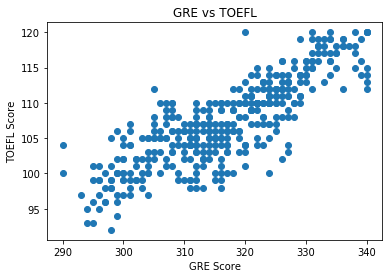

In [204]:
plt.scatter(df['GRE Score'], df['TOEFL Score'])
plt.title("GRE vs TOEFL")
plt.xlabel("GRE Score")
plt.ylabel("TOEFL Score")

b)Split the dataframe into 5 part, i.e. `numsplit` = 5, and compute `k_fold`.

In [205]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 

X_tr, X_te, Y_tr, Y_te = train_test_split(X, y, test_size=0.25)

numsplit = 5
k_fold = KFold(numsplit,shuffle=True, random_state=42)


c) Build linear regression model and finish `rmse` function.

In [158]:
from sklearn import linear_model
model = linear_model.LinearRegression()

def rmse(y_real, y_predict):
    return np.sqrt(np.mean((y_real - y_predict) ** 2))

d) Finish `rmse_kfold` function, and print the average rmse error.

In [159]:
def rmse_kfold(X_tr):
    err = []
    for train_idx, valid_idx in k_fold.split(X_tr):
        split_X_train, split_X_valid = X_tr.iloc[train_idx], X_tr.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_tr.iloc[train_idx], Y_tr.iloc[valid_idx]
        model.fit(split_X_train,split_Y_train)

    train_err = rmse(split_Y_valid,model.predict(split_X_valid))
    err.append(train_err)
    return np.mean(err)


In [160]:
rmse_err = rmse_kfold(X_tr)
print("The rmse error by using K-Fold is", rmse_err)

The rmse error by using K-Fold is 0.34164568384999144


# Decision Tree
Now let's briefly introduce you to decision tree. Tree-based algorithms are a popular family of related non-parametric and supervised methods for both classification and regression. If you're wondering what supervised learning is, it's the type of machine learning algorithms which involve training models with data that has both input and output labels (in other words, we have data for which we know the true class or values, and can tell the algorithm what these are if it predicts incorrectly).

The decision tree looks like a vague upside-down tree with a decision rule at the root, from which subsequent decision rules spread out below. 

Suppose we have four objects to classify: hawk, penguin, dolphin, and bear. It turns out that we can use a decision tree to correctly classify these four animals based on three features: "has feathers?", "Can fly", and "Has finns"

<img src="https://cdn-images-1.medium.com/max/824/0*J2l5dvJ2jqRwGDfG.png">

A numerical representation of decision tree will be a threshold of a specific feature. Let's look at our data as an example. We limit our decision tree depth to 3 to prevent overfitting.

Accuracy of a single decision tree:0.83


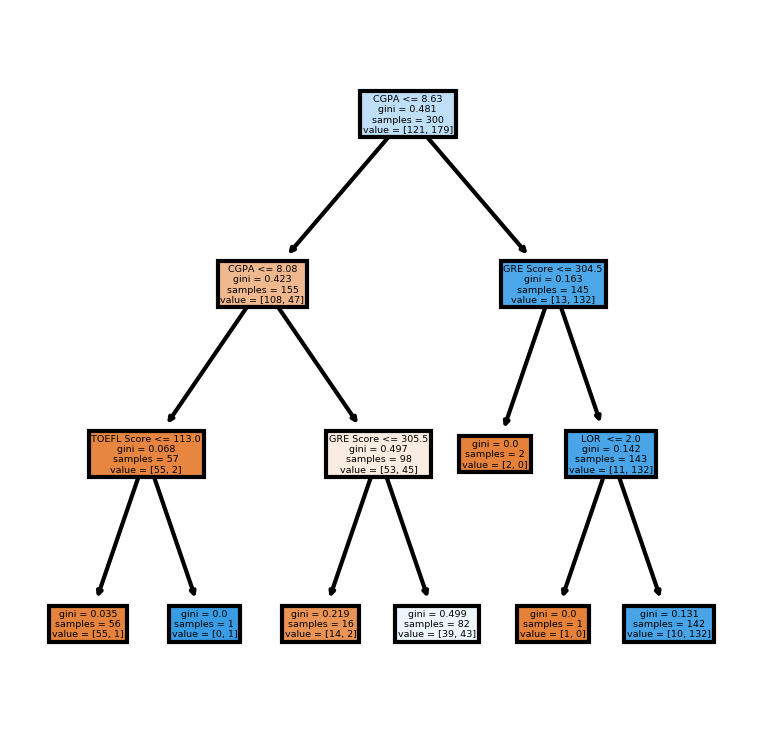

In [286]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree
dt = DecisionTreeClassifier(max_depth = 3)
predY = dt.fit(X_tr, Y_tr).predict(X_te)
predY[predY >= 0.5] = 1
predY[predY != 1] = 0
print("Accuracy of a single decision tree:" + str(accuracy_score(Y_te, predY)))
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=300)
axes.set_title('College Admission Decision Tree')
_ = tree.plot_tree(dt, 
                   feature_names=X.columns,  
                   filled=True)

It turns out that GPA is still the most important feature for graduate school admission, followed by TOEFL and GRE. Go bears!

# Overfitting
Overfitting: Or Why a Forest is better than One Tree
The reason the decision tree is prone to overfitting when we don’t limit the maximum depth is because it has unlimited flexibility, meaning that it can keep growing until it has exactly one leaf node for every single observation, perfectly classifying all of them. But we have reduced the variance of the decision tree but at the cost of increasing the bias, resulting in a lower test accuracy


In [317]:
dt = DecisionTreeClassifier(max_depth = 100) #TODO: change max_depth here
dt = dt.fit(X_tr, Y_tr)
predY_tr = dt.predict(X_tr)
predY_tr[predY_tr >= 0.5] = 1
predY_tr[predY_tr != 1] = 0
predY = dt.predict(X_te)
predY[predY >= 0.5] = 1
predY[predY != 1] = 0
print("Training accuracy:" + str(accuracy_score(Y_tr, predY_tr)))
print("Testing accuracy:" + str(accuracy_score(Y_te, predY)))

Training accuracy:1.0
Testing accuracy:0.81


a) Try out on the different max depth of decision tree and report when the accuracy reaches 1 for training data and when the test accuracy reaches maximum.

Your answer: 

# Bagging them together
Intuitively, a single tree may not be clever enough to classify our master school students. Now our goal is to implement a model that bags results of multiple decision trees and explore whether bagging is actually going to improve our model.

In [318]:
from sklearn.utils import resample
class BaggedTrees:

    def __init__(self, params=None, n=200):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.decision_trees = [
            DecisionTreeClassifier(max_depth = 3, random_state = i, **self.params)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        for i in range(self.n):
            #change the following line with bootstrapping
            self.decision_trees[i].fit(X_tr, Y_tr)
            #solution
            newX, newy = resample(X_tr, Y_tr, replace = True)
            self.decision_trees[i].fit(newX, newy)
        return self

    def predict(self, X):
        yhat = [self.decision_trees[i].predict(X) for i in range(self.n)]
        # TODO: compute yhat_avg for BaggedTrees
        # HINT: take the average and predict results, note that our prediction only consists of 0 and 1
        ### start code ###
        yhat_avg = np.average(yhat, axis = 0)
        yhat_avg = np.array([int(np.heaviside(i-1/2, 1/2)) for i in yhat_avg])
        ### end code ###
        return yhat_avg

In [319]:
bt = BaggedTrees()
predY = bt.fit(X_tr, Y_tr).predict(X_te)
predY[predY >= 0.5] = 1
predY[predY != 1] = 0
print(accuracy_score(Y_te, predY))

0.93


As you can see the accuracy of testing data is getting better after averaging the result from 100 decision trees or any number of decision trees (change n).

# Random Forest
You just implemented a random forest by yourself! Congratulations. Random Forest is a tree-based machine learning algorithm that leverages the power of multiple decision trees for making decisions. As the name suggests, it is a “forest” of trees!

But why do we call it a “random” forest? That’s because it is a forest of randomly created decision trees. As you can see from the skeleton code above -- we set the random state for each decision tree and thus each node in the decision tree works on a random subset of features to calculate the output. The random forest then combines the output of individual decision trees to generate the final output.

And that is our bagged trees. Let's see the result of random forest implemented by sklearn.

In [320]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth = 3,n_estimators = 50,random_state=1)
predY = rf.fit(X_tr, Y_tr).predict(X_te)
predY[predY >= 0.5] = 1
predY[predY != 1] = 0
print(accuracy_score(Y_te, predY))

0.91


<img src = "https://miro.medium.com/max/500/1*10t9S7xvWE5Z3NEZrmHG2w.jpeg">
<center>This is bagging, try to get the intuition here.</center>

# Reference
https://blog.paperspace.com/decision-trees/